In [1]:
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
df.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
271,61,1,3,134,234,0,1,145,0,2.6,1,2,2,0
241,59,0,0,174,249,0,1,143,1,0.0,1,0,2,0
30,41,0,1,105,198,0,1,168,0,0.0,2,1,2,1
57,45,1,0,115,260,0,0,185,0,0.0,2,0,2,1
294,44,1,0,120,169,0,1,144,1,2.8,0,0,1,0


In [4]:
df.shape

(303, 14)

In [5]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
features = df.drop(columns='target')
target = df[['target']]

In [7]:
categorical_features = features[['sex', 'fbs', 'exang', 'cp', 'ca', 'slope', 'thal', 'restecg']].copy()
categorical_features.head()

,sex,fbs,exang,cp,ca,slope,thal,restecg
0,1,1,0,3,0,0,1,0
1,1,0,0,2,0,0,2,1
2,0,0,0,1,0,2,2,0
3,1,0,0,1,0,2,2,1
4,0,0,1,0,0,2,2,1


In [8]:
numeric_features = features[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].copy()
numeric_features.head()

,age,trestbps,chol,thalach,oldpeak
0,63,145,233,150,2.3
1,37,130,250,187,3.5
2,41,130,204,172,1.4
3,56,120,236,178,0.8
4,57,120,354,163,0.6


In [9]:
sc = StandardScaler()
numeric_features = pd.DataFrame(sc.fit_transform(numeric_features),
                                columns=numeric_features.columns,
                                index=numeric_features.index)

In [10]:
processed_features = pd.concat([numeric_features, categorical_features], axis=1, sort=False)
processed_features.head()

,age,trestbps,chol,thalach,oldpeak,sex,fbs,exang,cp,ca,slope,thal,restecg
0,0.952197,0.763956,-0.256334,0.015443,1.087338,1,1,0,3,0,0,1,0
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,1,0,0,2,0,0,2,1
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,0,0,0,1,0,2,2,0
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,1,0,0,1,0,2,2,1
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,0,0,1,0,0,2,2,1


In [11]:
X_train, X_test, y_train, y_test = train_test_split(processed_features,
                                                    target,
                                                    test_size=0.2)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15)

In [13]:
for data in [X_train, X_val, X_test, y_train, y_val, y_test]:
  print(data.shape)

(205, 13)
(37, 13)
(61, 13)
(205, 1)
(37, 1)
(61, 1)


In [18]:
def build_model():

  inputs = keras.Input(shape=(X_train.shape[1],))

  dense_layer_1 = layers.Dense(12, activation='relu')
  x = dense_layer_1(inputs)

  dropout_layer = layers.Dropout(0.3)
  x = dropout_layer(x)

  dense_layer_2 = layers.Dense(8, activation='relu')
  x = dense_layer_2(x)

  predictions_layer = layers.Dense(1, activation='sigmoid')
  predictions = predictions_layer(x)

  model = keras.Model(inputs=inputs, outputs=predictions)

  model.summary()

  model.compile(optimizer=keras.optimizers.Adam(0.001),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy',
                         keras.metrics.Precision(0.5),
                         keras.metrics.Recall(0.5)])
  
  return model

In [19]:
model = build_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_4 (Dense)             (None, 12)                168       
                                                                 
 dropout_1 (Dropout)         (None, 12)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 104       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


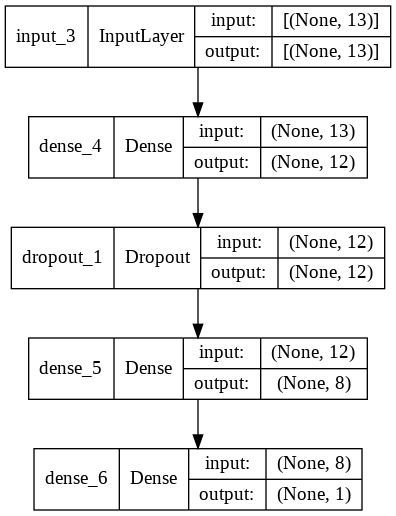

In [21]:
keras.utils.plot_model(model, show_shapes=True)

In [22]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
dataset_train = dataset_train.batch(16)
dataset_train.shuffle(128)

<ShuffleDataset shapes: ((None, 13), (None, 1)), types: (tf.float64, tf.int64)>

In [23]:
EPOCHS = 100

In [24]:
dataset_val = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))
dataset_val = dataset_val.batch(16)

In [25]:
history = model.fit(dataset_train, epochs=EPOCHS, validation_data=dataset_val)

Epoch 1/100
13/13 [==============================] - 3s 53ms/step - loss: 0.7367 - accuracy: 0.5171 - precision: 0.5401 - recall: 0.6727 - val_loss: 0.7869 - val_accuracy: 0.4054 - val_precision: 0.4688 - val_recall: 0.7500
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.7414 - accuracy: 0.4878 - precision: 0.5197 - recall: 0.6000 - val_loss: 0.7685 - val_accuracy: 0.4324 - val_precision: 0.4848 - val_recall: 0.8000
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.7518 - accuracy: 0.4634 - precision: 0.5000 - recall: 0.6273 - val_loss: 0.7508 - val_accuracy: 0.4054 - val_precision: 0.4688 - val_recall: 0.7500
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.7155 - accuracy: 0.4732 - precision: 0.5067 - recall: 0.6909 - val_loss: 0.7404 - val_accuracy: 0.4595 - val_precision: 0.5000 - val_recall: 0.8000
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 0.7249 - accuracy: 0.5024 - precis

In [29]:
history_df = pd.DataFrame(history.history, index = range(1, EPOCHS + 1))
history_df.head()

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
1,0.736703,0.517073,0.540146,0.672727,0.786913,0.405405,0.468750,0.75
2,0.741412,0.487805,0.519685,0.600000,0.768527,0.432432,0.484848,0.80
3,0.751760,0.463415,0.500000,0.627273,0.750762,0.405405,0.468750,0.75
4,0.715483,0.473171,0.506667,0.690909,0.740403,0.459459,0.500000,0.80
5,0.724934,0.502439,0.527397,0.700000,0.731002,0.459459,0.500000,0.80


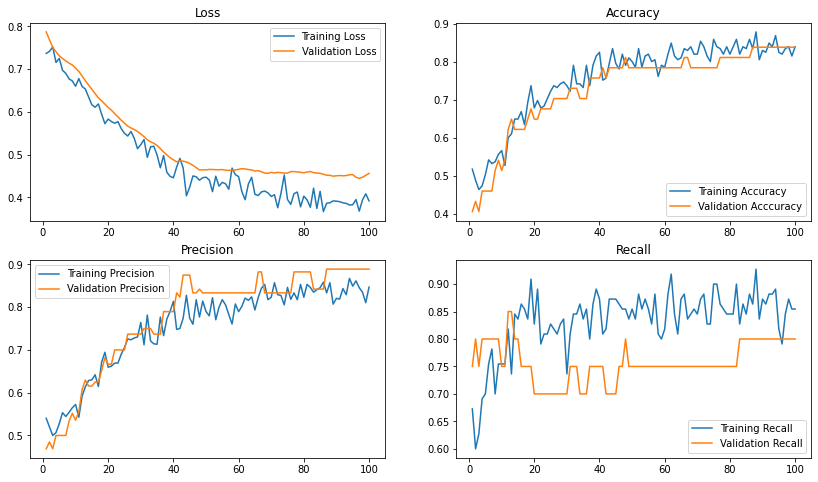

In [31]:
plt.figure(figsize=(14,8))

plt.subplot(2, 2, 2)
plt.plot(history_df.index, history_df.accuracy, label='Training Accuracy')
plt.plot(history_df.index, history_df.val_accuracy, label='Validation Acccuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 2, 1)
plt.plot(history_df.index, history_df.loss, label='Training Loss')
plt.plot(history_df.index, history_df.val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history_df.index, history_df.precision, label='Training Precision')
plt.plot(history_df.index, history_df.val_precision, label='Validation Precision')
plt.title('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history_df.index, history_df.recall, label='Training Recall')
plt.plot(history_df.index, history_df.val_recall, label='Validation Recall')
plt.title('Recall')
plt.legend();


In [33]:
pd.Series(model.evaluate(X_test, y_test), index=model.metrics_names)

2/2 [==============================] - 0s 12ms/step - loss: 0.3701 - accuracy: 0.8197 - precision: 0.8158 - recall: 0.8857


loss         0.370097
accuracy     0.819672
precision    0.815789
recall       0.885714
dtype: float64